In [10]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report, accuracy_score
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import skimage
import itertools

In [18]:
image_size = 128
batch_size = 64
num_classes = 4
epochs = 15
data_path = 'preprocess_128x128/train/'
test_path = 'preprocess_128x128/test/'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [19]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255) # set validation split

train_generator = train_datagen.flow_from_directory(data_path, target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    color_mode='grayscale',
                                                    class_mode='categorical',
                                                    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(data_path, target_size=(image_size,image_size),
                                                         batch_size=batch_size,
                                                         color_mode='grayscale',
                                                         class_mode='categorical',
                                                         subset='validation') # set as validation data


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_path, target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  color_mode='grayscale',
                                                  class_mode='categorical')


Found 66762 images belonging to 4 classes.
Found 16689 images belonging to 4 classes.
Found 957 images belonging to 4 classes.


In [20]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator.classes),
                                                  train_generator.classes)

In [21]:
model = Sequential()
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=(image_size, image_size,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(num_classes, activation='softmax'))

print(model.summary())

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 256)     2560      
_________________________________________________________________
batch_normalization_12 (Batc (None, 126, 126, 256)     1024      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 256)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 63, 63, 256)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 256)       590080    
_________________________________________________________________
batch_normalization_13 (Batc (None, 61, 61, 256)       1024      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 256)      

In [22]:
filepath="weights_balanced_cnn_5layered_best7.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Train the network
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples // batch_size,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.samples // batch_size,
                              epochs = epochs, 
                              callbacks=callbacks_list,
#                               class_weight=class_weights
                             )
model_json = model.to_json()
with open("custom_final.json", "w") as json_file:
    json_file.write(model_json)

Epoch 1/15


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[64,126,126,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Adam_2/gradients/zeros_38-0-1-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics_4/acc/Identity/_415]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[64,126,126,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Adam_2/gradients/zeros_38-0-1-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.




Test Loss: 0.015870387417574724
Test accuracy: 0.9958333333333333


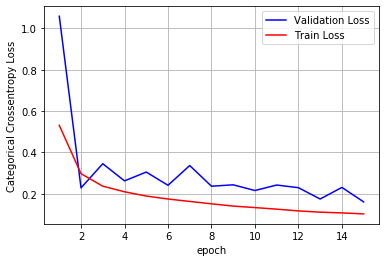

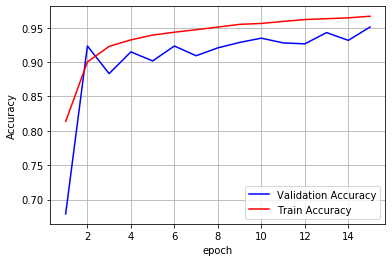

In [7]:
score = model.evaluate_generator(test_generator,steps = test_generator.samples // batch_size) 
print("\n\n")
print('Test Loss:', score[0])
print('Test accuracy:', score[1])
history = history.history
x = list(range(1,epochs+1))
_,ax1 = plt.subplots(1,1)
ax1.plot(x, history['val_loss'], 'b', label="Validation Loss")
ax1.plot(x, history['loss'], 'r', label="Train Loss")
ax1.set_xlabel('epoch') 
ax1.set_ylabel('Categorical Crossentropy Loss')
plt.legend()
plt.grid()
_,ax2 = plt.subplots(1,1)
ax2.plot(x, history['val_acc'], 'b', label="Validation Accuracy")
ax2.plot(x, history['acc'], 'r', label="Train Accuracy")
ax2.set_xlabel('epoch') 
ax2.set_ylabel('Accuracy')
plt.legend()
plt.grid()

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
#     plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [2]:
from tensorflow.keras.models import load_model
model = load_model('./model_custom.hdf5')

In [5]:


pred_datagen = ImageDataGenerator(rescale=1./255)

pred_generator = pred_datagen.flow_from_directory(test_path,target_size=(image_size, image_size),
                                                  batch_size=1,
                                                  color_mode='grayscale',
                                                  class_mode='categorical',
                                                  shuffle = False)   
pred_generator.reset()
y_pred = model.predict_generator(pred_generator,steps = pred_generator.samples)
Y_test = pred_generator.classes[pred_generator.index_array]
Y_pred = np.argmax(y_pred, axis=-1)
Y_pred = np.argmax(y_pred,axis = 1)



Found 999 images belonging to 4 classes.


--------------------
| Confusion Matrix |
--------------------

 [[250   0   0   0]
 [  0 250   0   0]
 [  3   0 246   0]
 [  0   0   1 249]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       250
           1       1.00      1.00      1.00       250
           2       1.00      0.99      0.99       249
           3       1.00      1.00      1.00       250

    accuracy                           1.00       999
   macro avg       1.00      1.00      1.00       999
weighted avg       1.00      1.00      1.00       999



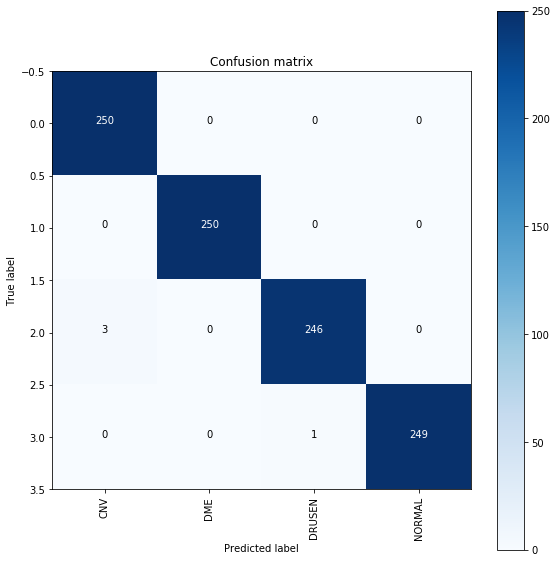

In [11]:
score = model.evaluate_generator(test_generator,steps = test_generator.samples // batch_size) 
print("\n\n")
print('Test Loss:', score[0])
print('Test accuracy:', score[1])
print('Test accuracy: ', accuracy_score())
# confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
 
print('--------------------')
print('| Confusion Matrix |')
print('--------------------')
print('\n {}'.format(cm))
print(classification_report(Y_test, Y_pred))
# plot confusin matrix
plt.figure(figsize=(8, 8))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['CNV','DME','DRUSEN','NORMAL'], normalize=False, 
                      title='Confusion matrix', cmap = plt.cm.Blues)
plt.show()


In [ ]:
import os
os._exit(00)